In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

!pip install tensorflow
!pip install keras
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install sklearn
!pip install glob
!pip install cv2

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [3]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg   
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from keras.metrics import AUC, Accuracy, Precision, SensitivityAtSpecificity
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import time
initial_time = time.time() #Time for the notebook starting to run

In [5]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

epos = 25 # Number of epochs to train
oversampling_flag = False

In [6]:
train_path = "train"
test_path= "test"

train_normal = glob.glob("train/NORMAL/*.jpeg")
train_pneumonia = glob.glob("train/PNEUMONIA/*.jpeg")

test_normal = glob.glob("test/NORMAL/*.jpeg")
test_pneumonia = glob.glob("test/PNEUMONIA/*.jpeg")

In [7]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

# <a id="3">Exploring the Data</a> 

Let's check the target distribution on each set

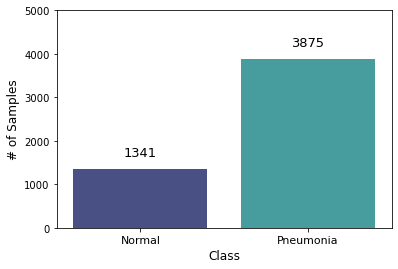

In [8]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

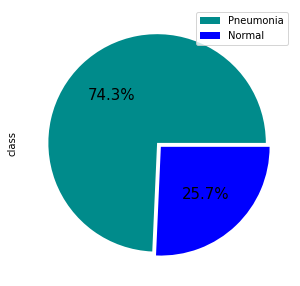

In [9]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

Train Set - Normal


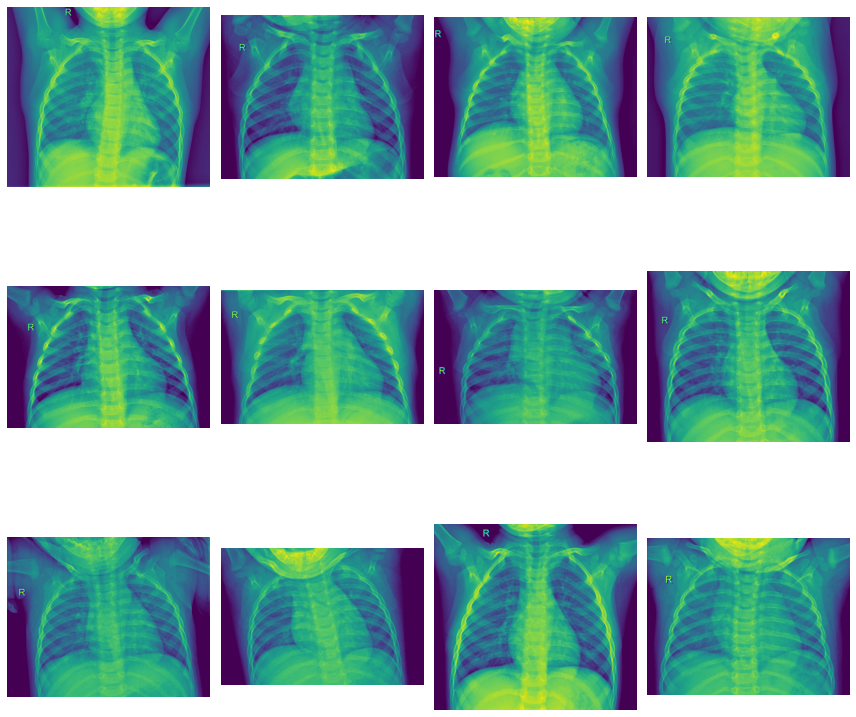

In [10]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = mpimg.imread(train_normal[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


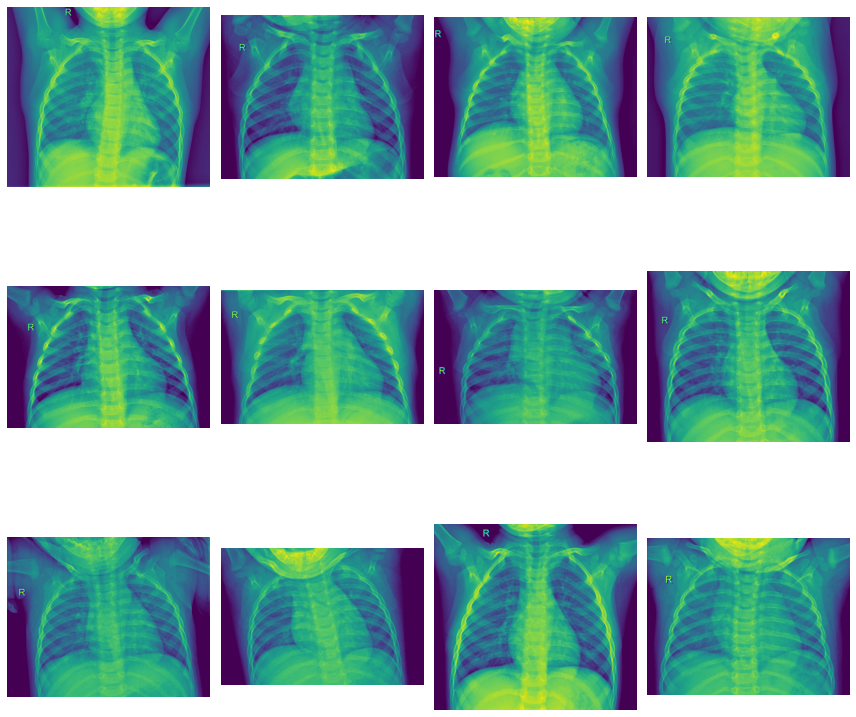

In [11]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = mpimg.imread(train_pneumonia[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# <a id="4">Preparing the Data</a> 

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [12]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

## oversampling

In [ ]:
if oversampling_flag:
    df_normal = train_df[train_df['class'] =='Normal']
    df_pneumonia =  train_df[train_df['class'] =='Pneumonia']

    size_diff = len(df_normal) - len(df_pneumonia)
    # If the pneumonia class has fewer samples than normal class
    if size_diff > 0:
        # Upsample the pneumonia class to match the size of the normal class
        df_pneumonia_upsampled = resample(df_pneumonia, replace=True, n_samples=size_diff+len(df_pneumonia))
        # Concatenate the upsampled pneumonia class with the normal class
        train_df = pd.concat([df_normal, df_pneumonia_upsampled], ignore_index=True)
    else:
        # Upsample the normal class to match the size of the pneumonia class
        df_normal_upsampled = resample(df_normal, replace=True, n_samples=-size_diff+len(df_normal))
        # Concatenate the upsampled normal class with the pneumonia class
        train_df = pd.concat([df_pneumonia, df_normal_upsampled], ignore_index=True)

## dataloading
Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [13]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


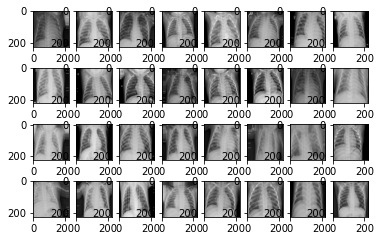

In [14]:
# retrieve a batch of images from the data generator
x_batch, y_batch = next(ds_train)
# plot the first 9 images in the batch
for i in range(32):
    # define subplot
    plt.subplot(4,8,i + 1)
    # plot raw pixel data
    plt.imshow(x_batch[i])
# show the figure
plt.show()

Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Transfer Learning</a> 

The approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/resnet/#resnet152v2-function). 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.



In [15]:
base_model_xception = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, 
     classes = 2)

base_model_resnet = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model_efficientnet = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classes=2,
    classifier_activation="softmax"
)

base_model_xception.trainable = False
base_model_resnet.trainable = False
base_model_efficientnet.trainable = False

def get_pretrained(architecture):
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if architecture.lower() == "xception":
        x = base_model_xception(inputs)
    elif architecture.lower() == "efficientnet":
        x = base_model_efficientnet(inputs)
    elif architecture.lower() == "resnet":
        x = base_model_resnet(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [16]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

# define the ModelCheckpoint callback

checkpoint_path_efficientnet = "model_checkpoint_efficientnet.h5"
checkpoint_callback_efficientnet = ModelCheckpoint(filepath=checkpoint_path_efficientnet,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

checkpoint_path_resnet = "model_checkpoint_resnet.h5"
checkpoint_callback_resnet = ModelCheckpoint(filepath=checkpoint_path_resnet,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

checkpoint_path_xception = "model_checkpoint_xception.h5"
checkpoint_callback_xception = ModelCheckpoint(filepath=checkpoint_path_xception,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

We now print the different models we are going to be comparing:

In [17]:
keras.backend.clear_session()

model_pretrained_xception = get_pretrained("xception")
model_pretrained_xception.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained_xception.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [18]:
keras.backend.clear_session()

model_pretrained_resnet = get_pretrained("resnet")
model_pretrained_resnet.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [19]:
keras.backend.clear_session()

model_pretrained_efficientnet = get_pretrained("efficientnet")
model_pretrained_efficientnet.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained_efficientnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129   

Now we train each model

In [20]:
with tf.device("/GPU:0"):
    history_xception = model_pretrained_xception.fit(ds_train,
          batch_size = BATCH, epochs = epos,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback_xception],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));
    
    history_resnet = model_pretrained_resnet.fit(ds_train,
          batch_size = BATCH, epochs = epos,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback_resnet],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));
    
    history_efficientnet = model_pretrained_efficientnet.fit(ds_train,
          batch_size = BATCH, epochs = epos,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback_efficientnet],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/25
130/130 [==============================] - 120s 875ms/step - loss: 0.3546 - binary_accuracy: 0.8401 - val_loss: 0.2473 - val_binary_accuracy: 0.9109 - lr: 5.0000e-05
Epoch 2/25
130/130 [==============================] - 110s 847ms/step - loss: 0.2107 - binary_accuracy: 0.9199 - val_loss: 0.1997 - val_binary_accuracy: 0.9282 - lr: 5.0000e-05
Epoch 3/25
130/130 [==============================] - 111s 850ms/step - loss: 0.1792 - binary_accuracy: 0.9314 - val_loss: 0.1706 - val_binary_accuracy: 0.9368 - lr: 5.0000e-05
Epoch 4/25
130/130 [==============================] - 108s 829ms/step - loss: 0.1624 - binary_accuracy: 0.9360 - val_loss: 0.1622 - val_binary_accuracy: 0.9425 - lr: 5.0000e-05
Epoch 5/25
130/130 [==============================] - 111s 854ms/step - loss: 0.1540 - binary_accuracy: 0.9389 - val_loss: 0.1749 - val_binary_accuracy: 0.9397 - lr: 5.0000e-05
Epoch 6/25
130/130 [==============================] - 109s 834ms/step - loss: 0.1458 - binary_accuracy: 0.9432 - va

Epoch 11/25
130/130 [==============================] - 114s 872ms/step - loss: 0.3125 - binary_accuracy: 0.8576 - val_loss: 0.3266 - val_binary_accuracy: 0.8678 - lr: 5.0000e-05
Epoch 12/25
130/130 [==============================] - 113s 868ms/step - loss: 0.3088 - binary_accuracy: 0.8670 - val_loss: 0.3174 - val_binary_accuracy: 0.8736 - lr: 5.0000e-05
Epoch 13/25
130/130 [==============================] - 113s 864ms/step - loss: 0.3052 - binary_accuracy: 0.8663 - val_loss: 0.3194 - val_binary_accuracy: 0.8745 - lr: 5.0000e-05
Epoch 14/25
130/130 [==============================] - 113s 866ms/step - loss: 0.3039 - binary_accuracy: 0.8670 - val_loss: 0.3154 - val_binary_accuracy: 0.8745 - lr: 5.0000e-05
Epoch 15/25
130/130 [==============================] - 113s 869ms/step - loss: 0.2928 - binary_accuracy: 0.8758 - val_loss: 0.3077 - val_binary_accuracy: 0.8745 - lr: 5.0000e-05
Epoch 16/25
130/130 [==============================] - 113s 870ms/step - loss: 0.2959 - binary_accuracy: 0.868

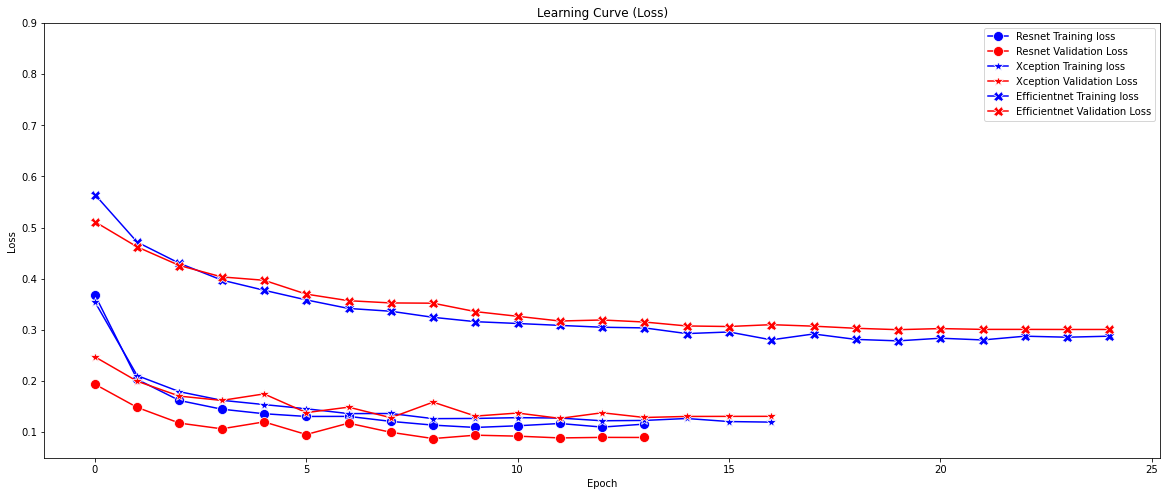

In [24]:
fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['loss'], label = "Resnet Training loss", marker = "o", color = "blue", markersize = 10)
sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['val_loss'], label = "Resnet Validation Loss", marker = "o", color = "red", markersize = 10)

sns.lineplot(x = history_xception.epoch, y = history_xception.history['loss'], label = "Xception Training loss", marker = "*", color = "blue", markersize = 10)
sns.lineplot(x = history_xception.epoch, y = history_xception.history['val_loss'], label = "Xception Validation Loss", marker = "*", color = "red", markersize = 10)

sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['loss'], label = "Efficientnet Training loss", marker = "X", color = "blue", markersize = 10)
sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['val_loss'], label = "Efficientnet Validation Loss", marker = "X", color = "red", markersize = 10)

ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0.05, 0.9)
ax.legend()
plt.savefig("Loss_curve_before_fine-tuning.pdf")
plt.show()

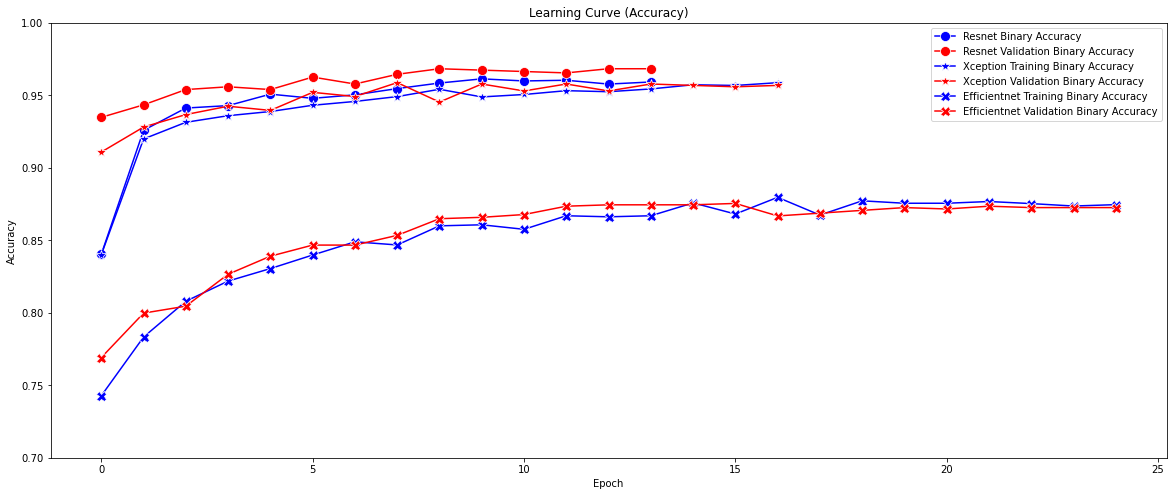

In [27]:
fig, ax = plt.subplots(figsize=(20,8))


sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['binary_accuracy'], label = "Resnet Binary Accuracy", marker = "o", color = "blue", markersize = 10)
sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['val_binary_accuracy'], label = "Resnet Validation Binary Accuracy", marker = "o", color = "red", markersize = 10)

sns.lineplot(x = history_xception.epoch, y = history_xception.history['binary_accuracy'], label = "Xception Training Binary Accuracy", marker = "*", color = "blue", markersize = 10)
sns.lineplot(x = history_xception.epoch, y = history_xception.history['val_binary_accuracy'], label = "Xception Validation Binary Accuracy", marker = "*", color = "red", markersize = 10)

sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['binary_accuracy'], label = "Efficientnet Training Binary Accuracy", marker = "X", color = "blue", markersize = 10)
sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['val_binary_accuracy'], label = "Efficientnet Validation Binary Accuracy", marker = "X", color = "red", markersize = 10)


ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.7, 1.0)
ax.legend()
plt.savefig("Accuracy_curve_before_fine-tuning.pdf")
plt.show()

### Now we print the acccuracy of the models:

In [28]:
val_accuracies = []

In [29]:
score = model_pretrained_xception.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print("Scores for the Xception model:")
print('Val loss:', score[0])
print('Val accuracy:', score[1])
val_accuracies.append(score[1])

Scores for the Xception model:
Val loss: 0.12707501649856567
Val accuracy: 0.9578543901443481


In [30]:
score = model_pretrained_resnet.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print("Scores for the resnet model:")
print('Val loss:', score[0])
print('Val accuracy:', score[1])
val_accuracies.append(score[1])

Scores for the resnet model:
Val loss: 0.08758118748664856
Val accuracy: 0.9683908224105835


In [31]:
score = model_pretrained_efficientnet.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print("Scores for the efficientnet model:")
print('Val loss:', score[0])
print('Val accuracy:', score[1])
val_accuracies.append(score[1])

Scores for the efficientnet model:
Val loss: 0.3004365563392639
Val accuracy: 0.8726053833961487


### And we now evalute all models:

In [32]:
test_accuracies = []
score = model_pretrained_xception.evaluate(ds_test, steps = len(df_test), verbose = 0)
print("Evaluation for the for the xception model:")
print('Test loss:', score[0])
print('Test accuracy:', score[1])
test_accuracies.append(score[1])

Evaluation for the for the xception model:
Test loss: 0.38191142678260803
Test accuracy: 0.8493589758872986


In [33]:
score = model_pretrained_resnet.evaluate(ds_test, steps = len(df_test), verbose = 0)
print("Evaluation for the for the resnet model:")
print('Test loss:', score[0])
print('Test accuracy:', score[1])
test_accuracies.append(score[1])

Evaluation for the for the resnet model:
Test loss: 0.45063117146492004
Test accuracy: 0.8285256624221802


In [34]:
score = model_pretrained_efficientnet.evaluate(ds_test, steps = len(df_test), verbose = 0)
print("Evaluation for the for the efficientnet model:")
print('Test loss:', score[0])
print('Test accuracy:', score[1])
test_accuracies.append(score[1])

Evaluation for the for the efficientnet model:
Test loss: 0.5515561103820801
Test accuracy: 0.7612179517745972


In [35]:
before_fine_tuning = {"Model":["Xception", "Resnet", "Efficientnet"], "Validation Accuracy":val_accuracies, "Test Accuracy":test_accuracies}
before_fine_tuning = pd.DataFrame(before_fine_tuning)



In [36]:
before_fine_tuning

Model  Validation Accuracy  Test Accuracy
0      Xception             0.957854       0.849359
1        Resnet             0.968391       0.828526
2  Efficientnet             0.872605       0.761218

In [37]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Validation Accuracy',
    x=['Xception', 'Resnet', 'Efficientnet'], y=val_accuracies, text = val_accuracies))
fig.add_trace(go.Bar(
    name='Test Accuracy',
    x=['Xception', 'Resnet', 'Efficientnet'], y=test_accuracies, text=test_accuracies
))
fig.update_layout(
    title="Accuracies before fine tuning the models",
    xaxis_title="Model",
    yaxis_title="Arbitrary units",
    legend_title="Dataset",
    barmode='group'
)

fig.show()
fig.write_image("Accuracies_before_fine-tuning.pdf")

# <a id="7">Fine Tuning</a> 

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [38]:
base_model_xception.trainable = True
base_model_resnet.trainable = True
base_model_efficientnet.trainable = True

# Unfreeze all layers except for the last 13
#for layer in base_model.layers[:-13]:
#    layer.trainable = False

unfreeze_xception = 2 #Highest numbers
unfreeze_resnet = 3
unfreeze_efficientnet = 4

### We unfreeze the models:

count = 0    
for layer in base_model_xception.layers[::-1]: #We reverse the array
    if ("conv" in layer.name) and (count < unfreeze_xception):
        count += 1
    else:
        layer.trainable = False

In [39]:
"""
Unfreezing for xception layers
"""

for layer in base_model_xception.layers[:-unfreeze_xception]:
    layer.trainable = False

count = 0    
for layer in base_model_resnet.layers[::-1]: #We reverse the array
    if ("conv" in layer.name) and (count < unfreeze_resnet):
        count += 1
    else:
        layer.trainable = False

In [40]:
"""
Unfreezing for resnet layers
"""

for layer in base_model_resnet.layers[:-unfreeze_resnet]:
    layer.trainable = False

count = 0    
for layer in base_model_efficientnet.layers[::-1]: #We reverse the array
    if ("conv" in layer.name) and (count < unfreeze_efficientnet):
        count += 1
    else:
        layer.trainable = False

In [41]:
"""
Unfreezing for efficientnet layers
"""

for layer in base_model_efficientnet.layers[:-unfreeze_efficientnet]:
    layer.trainable = False

### And now we we see the summary of these new models to be trained:

In [42]:
model_pretrained_xception = get_pretrained("xception")
model_pretrained_xception.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

print("Summary of Xception model:")
model_pretrained_xception.summary()

Summary of Xception model:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                

In [43]:
model_pretrained_resnet = get_pretrained("resnet")
model_pretrained_resnet.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

print("Summary of Resnet model:")
model_pretrained_resnet.summary()

Summary of Resnet model:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                  

In [44]:
model_pretrained_efficientnet = get_pretrained("efficientnet")
model_pretrained_efficientnet.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

print("Summary of Efficientnet model:")
model_pretrained_efficientnet.summary()

Summary of Efficientnet model:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)            

### Now we train the model:

In [45]:
with tf.device("/GPU:0"):
    history_xception = model_pretrained_xception.fit(ds_train,
          batch_size = BATCH, epochs = epos,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback_xception],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/25
130/130 [==============================] - 113s 848ms/step - loss: 0.7318 - binary_accuracy: 0.4142 - val_loss: 0.6927 - val_binary_accuracy: 0.5307 - lr: 2.0000e-06
Epoch 2/25
130/130 [==============================] - 109s 838ms/step - loss: 0.6370 - binary_accuracy: 0.6937 - val_loss: 0.6045 - val_binary_accuracy: 0.7615 - lr: 2.0000e-06
Epoch 3/25
130/130 [==============================] - 108s 831ms/step - loss: 0.5753 - binary_accuracy: 0.7656 - val_loss: 0.5520 - val_binary_accuracy: 0.7826 - lr: 2.0000e-06
Epoch 4/25
130/130 [==============================] - 109s 833ms/step - loss: 0.5299 - binary_accuracy: 0.7713 - val_loss: 0.5134 - val_binary_accuracy: 0.7797 - lr: 2.0000e-06
Epoch 5/25
130/130 [==============================] - 108s 829ms/step - loss: 0.4940 - binary_accuracy: 0.7778 - val_loss: 0.4841 - val_binary_accuracy: 0.7835 - lr: 2.0000e-06
Epoch 6/25
130/130 [==============================] - 108s 826ms/step - loss: 0.4695 - binary_accuracy: 0.7833 - va

In [46]:
with tf.device("/GPU:0"):
    history_resnet = model_pretrained_resnet.fit(ds_train,
          batch_size = BATCH, epochs = epos,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback_resnet],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/25
130/130 [==============================] - 141s 1s/step - loss: 0.7982 - binary_accuracy: 0.3826 - val_loss: 0.6890 - val_binary_accuracy: 0.5738 - lr: 2.0000e-06
Epoch 2/25
130/130 [==============================] - 130s 1s/step - loss: 0.6768 - binary_accuracy: 0.6081 - val_loss: 0.6171 - val_binary_accuracy: 0.7031 - lr: 2.0000e-06
Epoch 3/25
130/130 [==============================] - 130s 1s/step - loss: 0.6103 - binary_accuracy: 0.7071 - val_loss: 0.5610 - val_binary_accuracy: 0.7462 - lr: 2.0000e-06
Epoch 4/25
130/130 [==============================] - 131s 1s/step - loss: 0.5597 - binary_accuracy: 0.7404 - val_loss: 0.5156 - val_binary_accuracy: 0.7567 - lr: 2.0000e-06
Epoch 5/25
130/130 [==============================] - 131s 1s/step - loss: 0.5215 - binary_accuracy: 0.7550 - val_loss: 0.4768 - val_binary_accuracy: 0.7682 - lr: 2.0000e-06
Epoch 6/25
130/130 [==============================] - 130s 1s/step - loss: 0.4833 - binary_accuracy: 0.7744 - val_loss: 0.4429 - v

In [47]:
with tf.device("/GPU:0"):    
    history_efficientnet = model_pretrained_efficientnet.fit(ds_train,
          batch_size = BATCH, epochs = epos,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback_efficientnet],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/25
130/130 [==============================] - 124s 883ms/step - loss: 0.6574 - binary_accuracy: 0.7354 - val_loss: 0.6395 - val_binary_accuracy: 0.7404 - lr: 2.0000e-06
Epoch 2/25
130/130 [==============================] - 112s 858ms/step - loss: 0.6339 - binary_accuracy: 0.7442 - val_loss: 0.6190 - val_binary_accuracy: 0.7414 - lr: 2.0000e-06
Epoch 3/25
130/130 [==============================] - 112s 856ms/step - loss: 0.6119 - binary_accuracy: 0.7445 - val_loss: 0.5990 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 4/25
130/130 [==============================] - 112s 858ms/step - loss: 0.5920 - binary_accuracy: 0.7500 - val_loss: 0.5796 - val_binary_accuracy: 0.7529 - lr: 2.0000e-06
Epoch 5/25
130/130 [==============================] - 112s 858ms/step - loss: 0.5741 - binary_accuracy: 0.7500 - val_loss: 0.5630 - val_binary_accuracy: 0.7634 - lr: 2.0000e-06
Epoch 6/25
130/130 [==============================] - 112s 859ms/step - loss: 0.5564 - binary_accuracy: 0.7538 - va

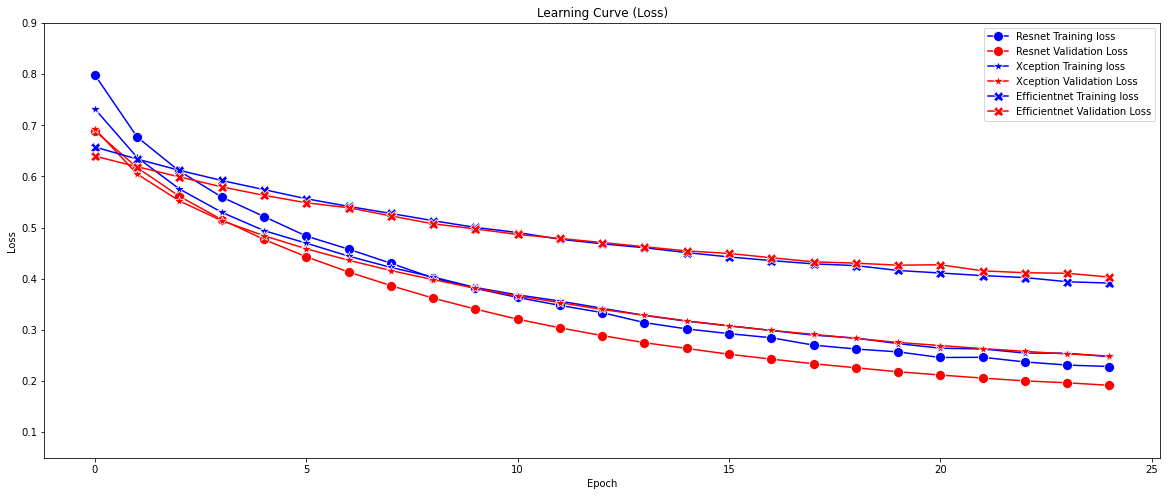

In [49]:
fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['loss'], label = "Resnet Training loss", marker = "o", color = "blue", markersize = 10)
sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['val_loss'], label = "Resnet Validation Loss", marker = "o", color = "red", markersize = 10)

sns.lineplot(x = history_xception.epoch, y = history_xception.history['loss'], label = "Xception Training loss", marker = "*", color = "blue", markersize = 10)
sns.lineplot(x = history_xception.epoch, y = history_xception.history['val_loss'], label = "Xception Validation Loss", marker = "*", color = "red", markersize = 10)

sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['loss'], label = "Efficientnet Training loss", marker = "X", color = "blue", markersize = 10)
sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['val_loss'], label = "Efficientnet Validation Loss", marker = "X", color = "red", markersize = 10)

ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0.05, 0.9)
ax.legend()
plt.savefig("Loss_curve_after_fine-tuning.pdf")
plt.show()

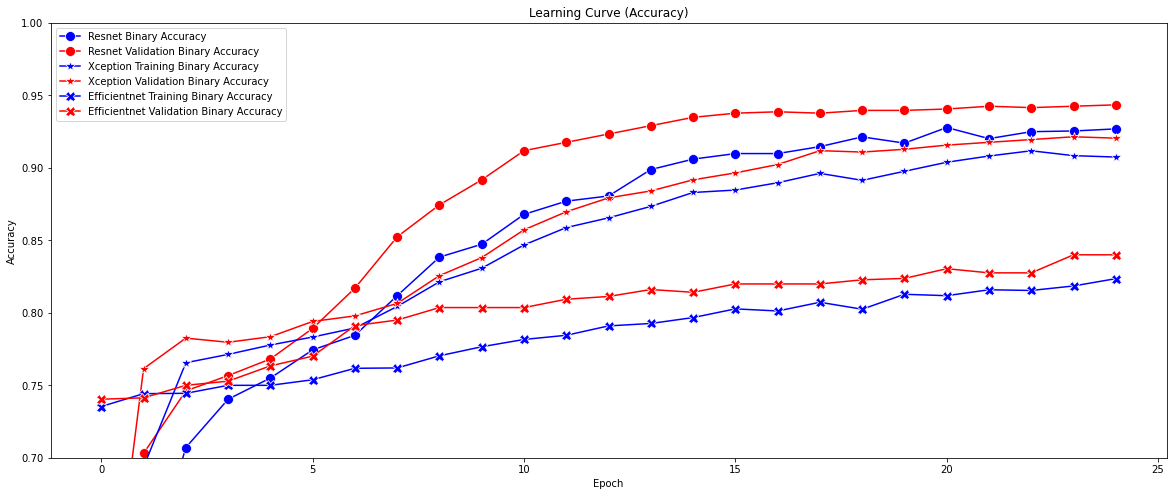

In [50]:
fig, ax = plt.subplots(figsize=(20,8))


sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['binary_accuracy'], label = "Resnet Binary Accuracy", marker = "o", color = "blue", markersize = 10)
sns.lineplot(x = history_resnet.epoch, y = history_resnet.history['val_binary_accuracy'], label = "Resnet Validation Binary Accuracy", marker = "o", color = "red", markersize = 10)

sns.lineplot(x = history_xception.epoch, y = history_xception.history['binary_accuracy'], label = "Xception Training Binary Accuracy", marker = "*", color = "blue", markersize = 10)
sns.lineplot(x = history_xception.epoch, y = history_xception.history['val_binary_accuracy'], label = "Xception Validation Binary Accuracy", marker = "*", color = "red", markersize = 10)

sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['binary_accuracy'], label = "Efficientnet Training Binary Accuracy", marker = "X", color = "blue", markersize = 10)
sns.lineplot(x = history_efficientnet.epoch, y = history_efficientnet.history['val_binary_accuracy'], label = "Efficientnet Validation Binary Accuracy", marker = "X", color = "red", markersize = 10)


ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.7, 1.0)
ax.legend()
plt.savefig("Accuracy_curve_after_fine-tuning.pdf")
plt.show()

### Now we print the acccuracy of the models again:

In [51]:
val_accuracies_after = []

In [52]:
score_xception = model_pretrained_xception.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print("Scores for the Xception model:")
print('Val loss:', score_xception[0])
print('Val accuracy:', score_xception[1])
val_accuracies_after.append(score_xception[1])

Scores for the Xception model:
Val loss: 0.2490396946668625
Val accuracy: 0.9204980731010437


In [53]:
score_resnet = model_pretrained_resnet.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print("Scores for the resnet model:")
print('Val loss:', score_resnet[0])
print('Val accuracy:', score_resnet[1])
val_accuracies_after.append(score_resnet[1])

Scores for the resnet model:
Val loss: 0.19164012372493744
Val accuracy: 0.9434865713119507


In [54]:
score_efficientnet = model_pretrained_efficientnet.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print("Scores for the efficientnet model:")
print('Val loss:', score_efficientnet[0])
print('Val accuracy:', score_efficientnet[1])
val_accuracies_after.append(score_efficientnet[1])

Scores for the efficientnet model:
Val loss: 0.4032168388366699
Val accuracy: 0.8400382995605469


### And we now evalute all models:

In [55]:
test_accuracies_after = []
score_xception = model_pretrained_xception.evaluate(ds_test, steps = len(df_test), verbose = 0)
print("Evaluation for the for the xception model:")
print('Test loss:', score_xception[0])
print('Test accuracy:', score_xception[1])
test_accuracies_after.append(score_xception[1])

Evaluation for the for the xception model:
Test loss: 0.4651944637298584
Test accuracy: 0.7852563858032227


In [56]:
score_resnet = model_pretrained_resnet.evaluate(ds_test, steps = len(df_test), verbose = 0)
print("Evaluation for the for the resnet model:")
print('Test loss:', score_resnet[0])
print('Test accuracy:', score_resnet[1])
test_accuracies_after.append(score_resnet[1])

Evaluation for the for the resnet model:
Test loss: 0.424398809671402
Test accuracy: 0.8044871687889099


In [57]:
score_efficientnet = model_pretrained_efficientnet.evaluate(ds_test, steps = len(df_test), verbose = 0)
print("Evaluation for the for the efficientnet model:")
print('Test loss:', score_efficientnet[0])
print('Test accuracy:', score_efficientnet[1])
test_accuracies_after.append(score_efficientnet[1])

Evaluation for the for the efficientnet model:
Test loss: 0.5827458500862122
Test accuracy: 0.6746794581413269


In [78]:
after_fine_tuning = {"Model":["Xception", "Resnet", "Efficientnet"], "Validation Accuracy":val_accuracies_after,
                      "Test Accuracy":test_accuracies_after, 
                     "Unfrozen layers":[unfreeze_xception, unfreeze_resnet, unfreeze_efficientnet]}
after_fine_tuning = pd.DataFrame(after_fine_tuning)



In [79]:
after_fine_tuning

Model  Validation Accuracy  Test Accuracy  Unfrozen layers
0      Xception             0.920498       0.785256                2
1        Resnet             0.943487       0.804487                3
2  Efficientnet             0.840038       0.674679                4

In [60]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Validation Accuracy',
    x=['Xception', 'Resnet', 'Efficientnet'], y=val_accuracies_after, text = val_accuracies_after))
fig.add_trace(go.Bar(
    name='Test Accuracy',
    x=['Xception', 'Resnet', 'Efficientnet'], y=test_accuracies_after, text = test_accuracies_after
))
fig.update_layout(
    title="Accuracies After fine tuning the models",
    xaxis_title="Model",
    yaxis_title="Arbitrary units",
    legend_title="Dataset",
    barmode='group'
)

fig.show()
fig.write_image("Accuracies_after_fine_tuning.pdf")

As expected, the fine-tuning approach has reached the best score. We end this notebook by showing a few performance metrics.

# <a id="8">Performance Metrics</a> 

### We now test all of our models:

In [61]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [62]:
ds_test.reset()

predictions_xception = model_pretrained_xception.predict(ds_test, steps=len(ds_test), verbose=0)
predictions_resnet = model_pretrained_resnet.predict(ds_test, steps=len(ds_test), verbose=0)
predictions_efficientnet = model_pretrained_efficientnet.predict(ds_test, steps=len(ds_test), verbose=0)


pred_labels_xception = np.where(predictions_xception >0.5, 1, 0)
pred_labels_resnet = np.where(predictions_resnet >0.5, 1, 0)
pred_labels_efficientnet = np.where(predictions_efficientnet >0.5, 1, 0)

In [63]:
print("Xception Accuracy: ", accuracy_score(Y_test, pred_labels_xception))
print("Resnet Accuracy: ", accuracy_score(Y_test, pred_labels_resnet))
print("Efficientnet Accuracy: ", accuracy_score(Y_test, pred_labels_efficientnet))

Xception Accuracy:  0.7852564102564102
Resnet Accuracy:  0.8044871794871795
Efficientnet Accuracy:  0.6746794871794872


### Visualizing the confusion matrix:

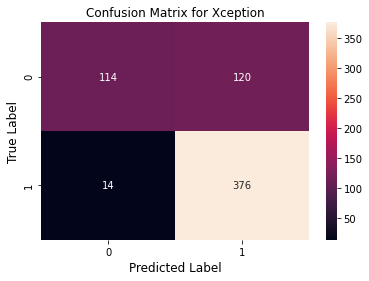

In [64]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels_xception)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.title("Confusion Matrix for Xception")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.savefig("Xception_confusion_matrix.pdf")
plt.show()

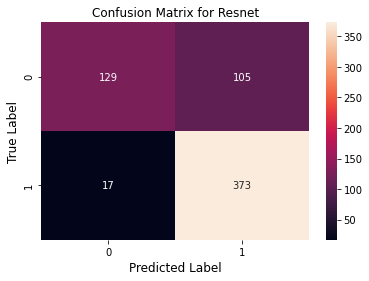

In [65]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels_resnet)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.title("Confusion Matrix for Resnet")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.savefig("Resnet_confusion_matrix.pdf")
plt.show()

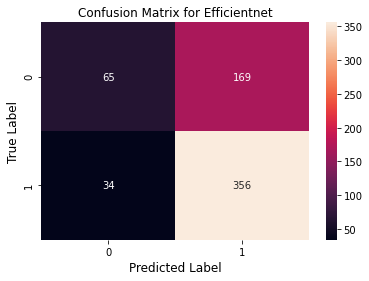

In [66]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels_efficientnet)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.title("Confusion Matrix for Efficientnet")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.savefig("Efficientnet_confusion_matrix.pdf")
plt.show()

### Metrics classification report for all models:

In [67]:
print(metrics.classification_report(Y_test, pred_labels_xception, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.89      0.49      0.63       234
           1       0.76      0.96      0.85       390

    accuracy                           0.79       624
   macro avg       0.82      0.73      0.74       624
weighted avg       0.81      0.79      0.77       624



In [68]:
print(metrics.classification_report(Y_test, pred_labels_resnet, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.88      0.55      0.68       234
           1       0.78      0.96      0.86       390

    accuracy                           0.80       624
   macro avg       0.83      0.75      0.77       624
weighted avg       0.82      0.80      0.79       624



In [69]:
print(metrics.classification_report(Y_test, pred_labels_efficientnet, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.66      0.28      0.39       234
           1       0.68      0.91      0.78       390

    accuracy                           0.67       624
   macro avg       0.67      0.60      0.58       624
weighted avg       0.67      0.67      0.63       624



### And finally, we plot the ROC curve:

ROC_AUC Xception:  0.8750821827744905
ROC_AUC Resnet:  0.9108152531229455
ROC_AUC Efficientnet:  0.7824676747753672


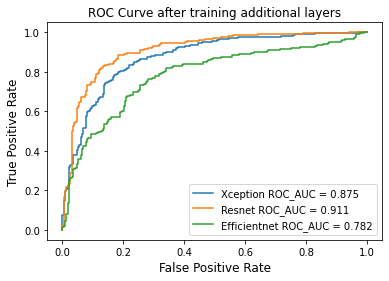

In [71]:
roc_auc_xception = metrics.roc_auc_score(Y_test, predictions_xception)
roc_auc_resnet = metrics.roc_auc_score(Y_test, predictions_resnet)
roc_auc_efficientnet = metrics.roc_auc_score(Y_test, predictions_efficientnet)

print('ROC_AUC Xception: ', roc_auc_xception)
print('ROC_AUC Resnet: ', roc_auc_resnet)
print('ROC_AUC Efficientnet: ', roc_auc_efficientnet)

fpr_xception, tpr_xception, thresholds_xception = metrics.roc_curve(Y_test, predictions_xception)
fpr_resnet, tpr_resnet, thresholds_resnet = metrics.roc_curve(Y_test, predictions_resnet)
fpr_efficientnet, tpr_efficientnet, thresholds_efficientnet = metrics.roc_curve(Y_test, predictions_efficientnet)

plt.plot(fpr_xception, tpr_xception, label = 'Xception ROC_AUC = %0.3f' % roc_auc_xception)
plt.plot(fpr_resnet, tpr_resnet, label = 'Resnet ROC_AUC = %0.3f' % roc_auc_resnet)
plt.plot(fpr_efficientnet, tpr_efficientnet, label = 'Efficientnet ROC_AUC = %0.3f' % roc_auc_efficientnet)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.title("ROC Curve after training additional layers")

plt.savefig("ROC_Curve_after_training_additional_layers.pdf")
plt.show()

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

In [ ]:
print("Total elapsed time:", time.time()- initial_time)

In [80]:
after_fine_tuning

Model  Validation Accuracy  Test Accuracy  Unfrozen layers
0      Xception             0.920498       0.785256                2
1        Resnet             0.943487       0.804487                3
2  Efficientnet             0.840038       0.674679                4

In [81]:
before_fine_tuning

Model  Validation Accuracy  Test Accuracy
0      Xception             0.957854       0.849359
1        Resnet             0.968391       0.828526
2  Efficientnet             0.872605       0.761218

In [90]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Validation Accuracy Before Fine Tuning', marker = {"color":"blue"},
    x=['Xception', 'Resnet', 'Efficientnet'], y=val_accuracies, text = val_accuracies))
fig.add_trace(go.Bar(
    name='Validation Accuracy After Fine Tuning',marker = {"color":"lightslategrey"},
    x=['Xception', 'Resnet', 'Efficientnet'], y=val_accuracies_after, text = val_accuracies_after
))
fig.update_layout(
    title="Validation accuracies comparison after and before fine tuning the models",
    xaxis_title="Model",
    yaxis_title="Arbitrary units",
    legend_title="Dataset",
    barmode='group'
)

fig.show()
fig.write_image("Accuracies_before_and_after_fine_tuning.pdf")

In [91]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Validation Accuracy Before Fine Tuning', marker = {"color":"red"},
    x=['Xception', 'Resnet', 'Efficientnet'], y=test_accuracies, text = test_accuracies))
fig.add_trace(go.Bar(
    name='Validation Accuracy After Fine Tuning',marker = {"color":"orange"},
    x=['Xception', 'Resnet', 'Efficientnet'], y=test_accuracies_after, text = test_accuracies_after
))
fig.update_layout(
    title="Validation accuracies comparison after and before fine tuning the models",
    xaxis_title="Model",
    yaxis_title="Arbitrary units",
    legend_title="Dataset",
    barmode='group'
)

fig.show()
fig.write_image("Test_Accuracies_before_and_after_fine_tuning.pdf")